<a href="https://colab.research.google.com/github/Peres-vinicius/breast-cancer-detection/blob/main/breast_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Importando Bibliotecas

In [37]:
import cv2
import glob
import zipfile
import numpy              as np
import pandas             as pd
import seaborn            as sns
import matplotlib.pyplot  as plt
from google.colab.patches import cv2_imshow   # utilizada somente no google colab
from google.colab         import drive
import matplotlib.image   as mpimg
#sns.set_theme()

# 2.0 Acessando o drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 3.0 Carregando os arquivos

In [3]:
path = '/content/gdrive/MyDrive/projetos-programação/datasets/Breast-Ultrasound-Images-Dataset/cancer-mama.zip' # INSERIR CAMINHO DO ARQUIVO ZIPADO
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

## - Visualizando exemplos

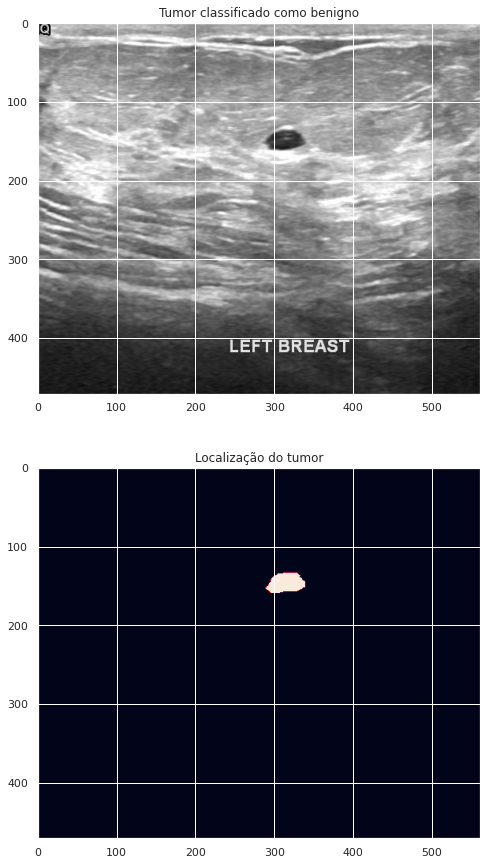

In [4]:
img1 = mpimg.imread('/content/Dataset_BUSI_with_GT/benign/benign (1).png') # endereço da imagem
img2 = mpimg.imread('/content/Dataset_BUSI_with_GT/benign/benign (1)_mask.png') # endereço da imagem
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.imshow(img1)
plt.title('Tumor classificado como benigno')


plt.subplot(2, 1, 2)
plt.imshow(img2)
plt.title('Localização do tumor')
plt.savefig('Exemplo_base_dados.png')
plt.show()

## Organizando as imagens

In [5]:
path = '/content/Dataset_BUSI_with_GT/'

classes = ['benign', 'malignant', 'normal']

total = []
type_of_tumor = []
nome_img = []
class_tumor = []


for i, classe in enumerate(classes):
  imgs_treinamento = glob.glob(path + classe + "/*") # verifica todos os arquivos dentro da pasta 


  for img in imgs_treinamento:
    aux = img.split('_')
    if len(aux) == 4:
   
      total.append(img);
      nome_img.append(str(img.split("/")[-1]))
      type_of_tumor.append(i)
      class_tumor.append(classe)

dataset = pd.DataFrame()

dataset["img"] = nome_img
dataset["type"] = type_of_tumor
dataset["class"] = class_tumor

In [6]:
dataset

,img,type,class
0,benign (358).png,0,benign
1,benign (79).png,0,benign
2,benign (386).png,0,benign
3,benign (84).png,0,benign
4,benign (34).png,0,benign
...,...,...,...
775,normal (100).png,2,normal
776,normal (75).png,2,normal
777,normal (52).png,2,normal
778,normal (60).png,2,normal


[]

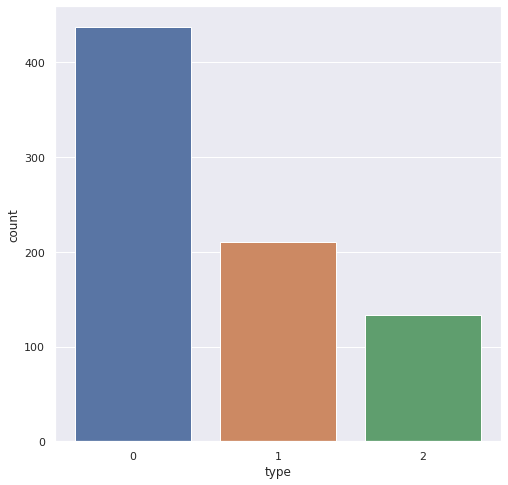

In [36]:
plt.figure(figsize=(8,8))
sns.countplot(x='type', data=dataset)
plt.plot()

In [8]:
dataset['type'].value_counts()

0    437
1    210
2    133
Name: type, dtype: int64

## Preparando as imagens

In [ ]:
total

In [10]:
import time

width, height = 300, 300

tumors = []
aux = 0 
t = time.time()
t_total = time.time()

for tumor in total:
  imagem = cv2.imread(tumor, 0)
   
  imagem = cv2.resize(imagem, (width, height))
  imagem = np.asarray(imagem).reshape(width, height)
  aux = aux + 1
  tumors.append(imagem)

In [11]:
len(tumors)

780

# 4.0 Pré-processamento

In [12]:
tumors = np.asarray(tumors) 
tumors = np.expand_dims(tumors, -1)

def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

tumors = normalizar(tumors)

In [13]:
tumors[0]

array([[[0.56078434],
        [0.6431373 ],
        [0.01176471],
        ...,
        [0.7607843 ],
        [0.67058825],
        [0.6156863 ]],

       [[0.17254902],
        [0.76862746],
        [0.00392157],
        ...,
        [0.68235296],
        [0.6039216 ],
        [0.57254905]],

       [[0.12156863],
        [0.7921569 ],
        [0.05882353],
        ...,
        [0.68235296],
        [0.60784316],
        [0.5411765 ]],

       ...,

       [[0.09803922],
        [0.09019608],
        [0.08627451],
        ...,
        [0.10980392],
        [0.10588235],
        [0.10588235]],

       [[0.11372549],
        [0.11372549],
        [0.09803922],
        ...,
        [0.08235294],
        [0.09019608],
        [0.09803922]],

       [[0.11372549],
        [0.11372549],
        [0.09803922],
        ...,
        [0.09019608],
        [0.10980392],
        [0.11372549]]], dtype=float32)

In [14]:
tumors.shape   #(qtd_image, width, height, canal de cor)

(780, 300, 300, 1)

In [15]:
type_of_tumor = pd.get_dummies(dataset['type'])

In [16]:
type_of_tumor.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# 5.0 - Tensorflow/Keras

In [17]:
from sklearn.model_selection       import train_test_split
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers       import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses       import categorical_crossentropy
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks    import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models       import load_model
from tensorflow.keras.models       import model_from_json

In [18]:
x_train, x_test, y_train, y_test = train_test_split(tumors, type_of_tumor, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 631
Número de imagens no conjunto de testes: 78
Número de imagens no conjunto de validação: 71


In [19]:
# Salvando estes dados para serem testados e gerar a matriz de confusão
path = '/content/Dataset_BUSI_with_GT/'
np.save(path + 'mod_xtest', x_test)
np.save(path + 'mod_ytest', y_test)

# 7.0 - Arquitetura do Modelo

In [20]:
num_features = 32
num_classes = 3
width, height = 300, 300
batch_size = 16
epochs = 70

model = Sequential()

model.add(Conv2D(num_features, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (width, height, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*2*num_features, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(2*2*num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_features, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      320       
                                                                 
 activation (Activation)     (None, 300, 300, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 300, 300, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 300, 300, 64)     256       
 hNormalization)                                        

# 8.0 Compilando o Modelo

In [21]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
# Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

arquivo_modelo = '/content/Dataset_BUSI_with_GT/' + "modelo_01.h5" # arquivo do modelo
arquivo_modelo_json = '/content/Dataset_BUSI_with_GT/' + "modelo_01.json" # arquivo do json, para salvar a arquitetura

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

## Salvando a arquitetura do modelo em um arquivo Json

In [22]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

# 9.0 - Treinando o modelo

In [23]:
x_train.shape

(631, 300, 300, 1)

In [24]:
history = model.fit(x_train,y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_val, y_val),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/70

Epoch 00001: val_loss improved from inf to 3.68252, saving model to /content/Dataset_BUSI_with_GT/modelo_01.h5
40/40 - 119s - loss: 1.4697 - accuracy: 0.4358 - val_loss: 3.6825 - val_accuracy: 0.2676 - lr: 0.0010 - 119s/epoch - 3s/step
Epoch 2/70

Epoch 00002: val_loss improved from 3.68252 to 1.02581, saving model to /content/Dataset_BUSI_with_GT/modelo_01.h5
40/40 - 107s - loss: 1.0996 - accuracy: 0.5182 - val_loss: 1.0258 - val_accuracy: 0.6197 - lr: 0.0010 - 107s/epoch - 3s/step
Epoch 3/70

Epoch 00003: val_loss did not improve from 1.02581
40/40 - 34s - loss: 0.8943 - accuracy: 0.6054 - val_loss: 1.0338 - val_accuracy: 0.5352 - lr: 0.0010 - 34s/epoch - 846ms/step
Epoch 4/70

Epoch 00004: val_loss improved from 1.02581 to 0.99445, saving model to /content/Dataset_BUSI_with_GT/modelo_01.h5
40/40 - 110s - loss: 0.8314 - accuracy: 0.6418 - val_loss: 0.9944 - val_accuracy: 0.5352 - lr: 0.0010 - 110s/epoch - 3s/step
Epoch 5/70

Epoch 00005: val_loss did not improve from 0.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


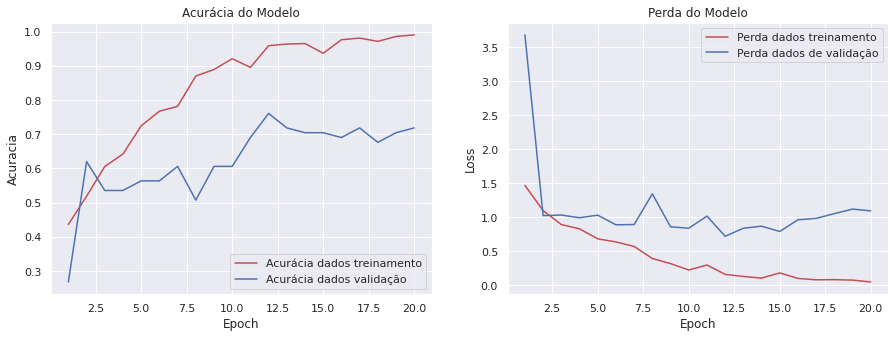

In [30]:
def plot_historic_model(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(history.history['accuracy'])+1),
                history.history['accuracy'],'r')
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),
                history.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),
                      len(history.history['accuracy'])/10)
    axs[0].legend(['Acurácia dados treinamento', 'Acurácia dados validação'], loc='best')

    axs[1].plot(range(1,len(history.history['loss'])+1),
                history.history['loss'],'r')
    axs[1].plot(range(1,len(history.history['val_loss'])+1),
                history.history['val_loss'],'b')
    axs[1].set_title('Perda do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),
                      len(history.history['loss'])/10)
    axs[1].legend(['Perda dados treinamento', 'Perda dados de validação'], loc='best')
    fig.savefig('historic_model.png')
    plt.show();

plot_historic_model(history)

# 10 - Métricas do modelo

In [31]:
scores = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

5/5 [==============================] - 1s 144ms/step - loss: 1.3742 - accuracy: 0.6410
Acurácia: 0.6410256624221802
Perda/Loss: 1.374200701713562


## Carregando os dados para gerar a matriz de confusão

In [27]:
true_y=[]
pred_y=[]
path = '/content/Dataset_BUSI_with_GT/'
x = np.load(path + 'mod_xtest.npy')
y = np.load(path + 'mod_ytest.npy')
#json_file = open(arquivo_modelo_json, 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
#loaded_model.load_weights(arquivo_modelo)
#y_pred= loaded_model.predict(x)
y_pred= model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save(path + 'truey__mod_alt', true_y)
np.save(path + 'predy__mod_alt', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 64.1025641025641%


In [34]:
from sklearn.metrics import confusion_matrix
y_true = np.load(path + 'truey__mod_alt.npy')
y_pred = np.load(path + 'predy__mod_alt.npy')
cm = confusion_matrix(y_true, y_pred)
aux = ['benign', 'malignant', 'normal']
#titulo='Matriz de Confusão'


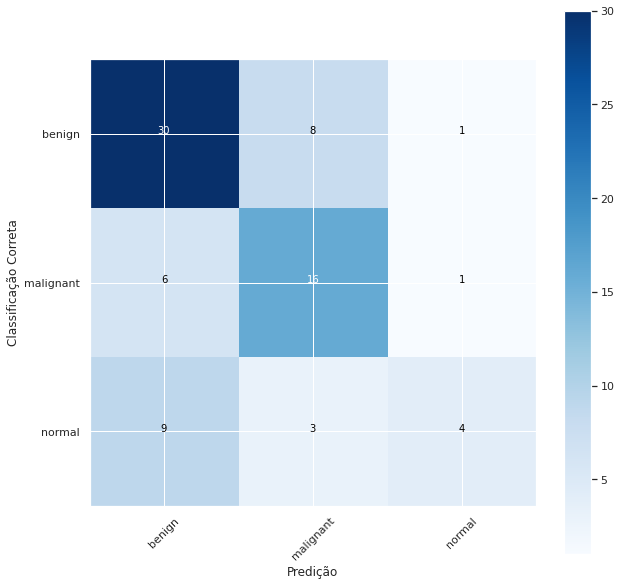

In [42]:
import itertools
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(aux))
plt.xticks(tick_marks, aux, rotation=45)
plt.yticks(tick_marks, aux)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod_alt.png')
plt.show()